In [147]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


In [86]:
# load a csv called data.csv with the separation character ','

geo_data = pd.read_csv('raw_data/geo_eth.csv', sep=',')
cons_data = pd.read_csv('raw_data/cons_eth.csv', sep=',')

In [87]:
geo_data.shape

(4954, 42)

In [47]:
cons_data.head()

,household_id,household_id2,ea_id,ea_id2,saq01,rural,pw_w3,adulteq,hh_size,no_conv,no_cons,food_cons_ann,nonfood_cons_ann,educ_cons_ann,total_cons_ann,price_index_hce,nom_totcons_aeq,cons_quint
0,1010101601002,10101088801601002,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,1970.800049,1013.0,0.0,2983.800049,1.034,4032.162109,2.0
1,1010101601017,10101088801601017,1010101601,10101088801601,1,1,2897.155029,7.21,9,0,0,7883.200195,5337.0,358.0,13578.200195,1.034,1883.245483,1.0
2,1010101601034,10101088801601034,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,8958.444458,322.0,0.0,9280.444336,1.034,12541.140625,5.0
3,1010101601049,10101088801601049,1010101601,10101088801601,1,1,2897.155029,2.50,3,0,0,9594.000000,1630.0,480.0,11704.000000,1.034,4681.600098,3.0
4,1010101601064,10101088801601064,1010101601,10101088801601,1,1,2897.155029,1.58,2,0,0,11702.888916,3272.0,0.0,14974.888672,1.034,9477.778320,5.0


In [48]:

COUNTRIES_DIR = os.path.join("..", 'data', 'countries')

In [49]:
def process_ethiopia():

    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household

    lat_col = 'lat_dd_mod'
    lon_col = 'lon_dd_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 7.882
    
    # for file in [consumption_file, geovariables_file]:
    #     assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df = cons_data
    df['cons_ph'] = df[consumption_pc_col] * df[hhsize_col]
    df['pph'] = df[hhsize_col]
    df['cons_ph'] = df['cons_ph'] / ppp / 365
    df = df[['household_id2', 'cons_ph', 'pph']]

    df_geo = geo_data
    df_cords = df_geo[['household_id2', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id2')
    df_combined.drop(['household_id2'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
  
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [50]:
data = process_ethiopia()

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_87404/1253664893.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)


In [71]:
import math
def create_space(lat, lon, s=1):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    return lat - v, lon - v, lat + v, lon + v

In [72]:
import rasterio

url_image = "raw_data/picture.tif"
with rasterio.open(url_image) as src:
    image_data = src.read(1)  
    transform = src.transform
    tif_array = np.squeeze(image_data)

    print(tif_array.shape)

(18000, 28800)


In [73]:
def custom_rasterio_open( min_lon, min_lat):
    xminPixel, ymaxPixel = ~transform * (min_lon, min_lat)

    xminPixel, ymaxPixel = int(xminPixel), int(ymaxPixel)
    
    return xminPixel, ymaxPixel

In [77]:
def add_nightlights(df, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_nightlights = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = custom_rasterio_open(min_lon, min_lat)
        xmaxPixel, yminPixel = custom_rasterio_open(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_nightlights.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    df['nightlights'] = cluster_nightlights

In [79]:
add_nightlights(data, tif_array)

In [82]:
data

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,3.455701,39.515994,14.854634,0.0
1,eth,3.549937,39.184234,14.312022,0.0
2,eth,3.864243,39.101366,12.470145,0.0
3,eth,3.982931,38.491368,8.336539,0.0
4,eth,4.048194,41.930928,4.762526,0.0
...,...,...,...,...,...
518,eth,14.288590,38.210252,13.926005,0.0
519,eth,14.300796,39.059489,6.882396,0.0
520,eth,14.319217,39.271599,5.894326,0.0
521,eth,14.353816,37.890876,8.197660,0.0


In [94]:
X = data[['nightlights']]
y = data['cons_pc']

In [90]:
X_non_zero = X[X != 0]

In [91]:
X_non_zero

23     0.035953
24     0.053930
31     0.226722
32     0.178416
36     9.478632
         ...   
506    1.018144
507    8.458162
510    5.779657
513    0.477778
516    2.939054
Name: nightlights, Length: 136, dtype: float32

<Axes: xlabel='nightlights', ylabel='Count'>

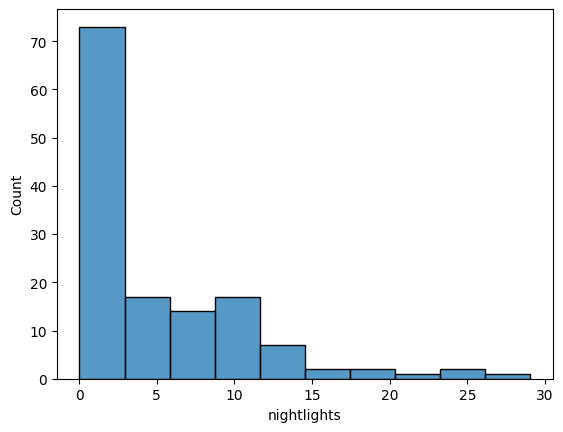

In [105]:
sns.histplot(X_non_zero)

<Axes: xlabel='nightlights', ylabel='cons_pc'>

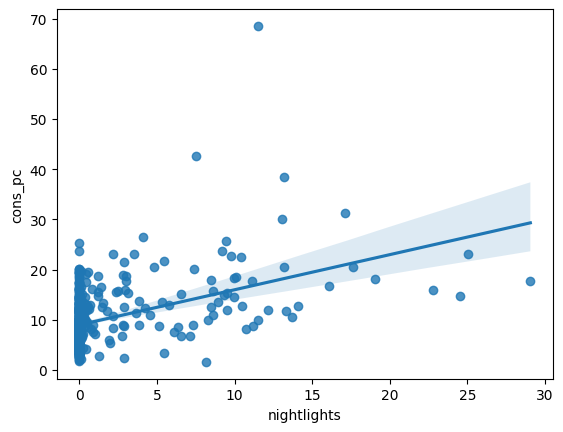

In [108]:
sns.regplot(x=X,y=y)

In [95]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [100]:
X_scaled = pd.DataFrame(X_scaled)

In [116]:
model = LinearRegression()
k_folds = KFold(n_splits=5)
scores = cross_val_score(model, X_scaled, y, cv = k_folds)
scores  

0.032343327616313935

In [154]:
scores

array([ 2.13625223e-01,  2.12959218e-04, -2.33696339e-01,  9.29250013e-02,
        8.86497942e-02])

In [121]:
data_Xy = data[['nightlights','cons_pc']]

In [123]:
data_Xy['nightlights'] = scaler.fit_transform(X)

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_87404/3084886050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Xy['nightlights'] = scaler.fit_transform(X)


In [151]:
data_Xy.head()

,nightlights,cons_pc
0,0.0,14.854634
1,0.0,14.312022
2,0.0,12.470145
3,0.0,8.336539
4,0.0,4.762526


In [162]:
data_Xy.corr()

,nightlights,cons_pc
nightlights,1.000000,0.440152
cons_pc,0.440152,1.000000


In [157]:
#split train and test data
train_data, test_data = train_test_split(data_Xy, test_size=0.3)

# Ready X's and y's
X_train = train_data[['nightlights']]
y_train = train_data['cons_pc']

X_test = test_data[['nightlights']]
y_test = test_data['cons_pc']

In [158]:
# Train the model on the Training data
model.fit(X_train, y_train)

# Score the model on the Test data
model.score(X_test,y_test)

0.20319840045769033

In [160]:
#K-fold CV without data leakage

n_split = 5
len_split = int(data_Xy.shape[0]/n_split)

# Initialize the 1st fold
scores = []
start = 0
stop = len_split

# Start the n-split fold CV
for k in range(n_split): # k in [0,1,2,3,4]
    data_val = data_Xy.iloc[start:stop, :]
    data_train = data_Xy.drop(index=data_val.index)
    y_train = data_train['cons_pc']
    X_train = data_train.drop(columns=['cons_pc'])
    y_val = data_val['cons_pc']
    X_val = data_val.drop(columns=['cons_pc'])
    
    #fit model
    model_k =  LinearRegression()
    model_k.fit(X_train, y_train)
    
    #append score to scores list
    scores.append(model_k.score(X_val, y_val))
    
    # Setup next fold
    start = stop
    stop += len_split

# Display the mean score and the scores standard deviation
print(np.array(scores).mean())
print(np.array(scores).std())

0.03723239805532743
0.14092490524978635


In [161]:
addis_ab_df = data[
    (data['cluster_lat'] >= 8.9) & (data['cluster_lat'] <= 9.1) &
    (data['cluster_lon'] >= 38.7) & (data['cluster_lon'] <= 38.9)
]

In [ ]:
#Get co-ords for city boundaries of next 10 most populous cities

dire_dawa_df = data[
    (data['cluster_lat'] >= 9.57) & (data['cluster_lat'] <= 9.64) &
    (data['cluster_lon'] >= 41.8) & (data['cluster_lon'] <= 41.9)
]
mekelle_df = 